In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()

#set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

In [6]:
!unzip 'sentiment-analysis-on-movie-reviews.zip'

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: train.tsv               
  inflating: test.tsv                


In [7]:

train= pd.read_csv("train.tsv", sep="\t")
test = pd.read_csv("test.tsv", sep="\t")

print(train.head())
train.shape
test.head()

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [14]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        # remove html content
        review_text = BeautifulSoup(sent).get_text()

        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]", " ", review_text)

        # tokenize the sentences
        words = word_tokenize(review_text.lower())

        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]

        reviews.append(lemma_words)

    return (reviews)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [15]:

# cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]

X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

100%|██████████| 66292/66292 [00:28<00:00, 2359.65it/s]


156060
66292


In [16]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):

    unique_words.update(sent)

    if (len_max < len(sent)):
        len_max = len(sent)

# length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 439186.55it/s]

13735
48


In [17]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_val.shape,X_test.shape)

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]


(124848, 48) (31212, 48) (66292, 48)


In [19]:
#Model using Keras LSTM
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 48, 300)           4120500   
_________________________________________________________________
lstm_3 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 4,396,561
Trainable params: 4,396,561
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=5, batch_size=256, verbose=1, callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 97s 781us/step - loss: 0.9987 - acc: 0.5976 - val_loss: 0.8487 - val_acc: 0.6470
Epoch 2/10
124848/124848 [==============================] - 95s 763us/step - loss: 0.8044 - acc: 0.6680 - val_loss: 0.8130 - val_acc: 0.6654
Epoch 3/10
124848/124848 [==============================] - 93s 748us/step - loss: 0.7351 - acc: 0.6929 - val_loss: 0.8131 - val_acc: 0.6715
Epoch 4/10
124848/124848 [==============================] - 93s 748us/step - loss: 0.6926 - acc: 0.7099 - val_loss: 0.8300 - val_acc: 0.6702
Epoch 5/10
124848/124848 [==============================] - 93s 748us/step - loss: 0.6660 - acc: 0.7188 - val_loss: 0.8432 - val_acc: 0.6659


In [0]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

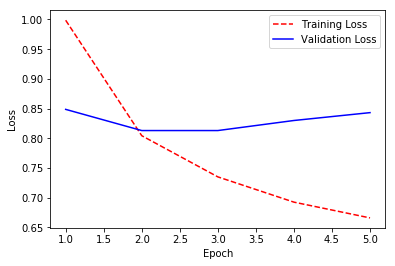

In [22]:
# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()